<a href="https://colab.research.google.com/github/AfefThabet/Reconnaissance-d-empreintes-digitales-endommagees/blob/main/Fing_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

# Load Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dnyaneshwalwadkar/fingerprintdata-npz")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fingerprintdata-npz


(6000, 90, 90, 1) (6000, 4)


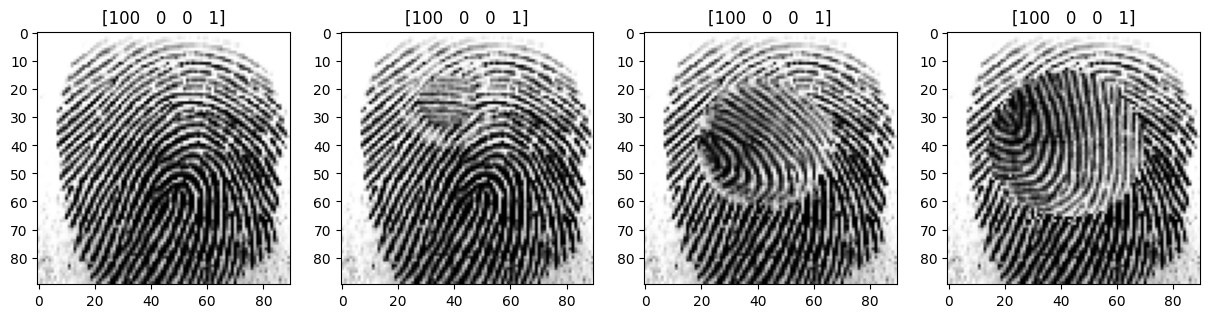

In [ ]:
x_real = np.load(path+'/dataset/x_real.npz')['data']
y_real = np.load(path+'/dataset/y_real.npy')
x_easy = np.load(path+'/dataset/x_easy.npz')['data']
y_easy = np.load(path+'/dataset/y_easy.npy')
x_medium = np.load(path+'/dataset/x_medium.npz')['data']
y_medium = np.load(path+'/dataset/y_medium.npy')
x_hard = np.load(path+'/dataset/x_hard.npz')['data']
y_hard = np.load(path+'/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Train Test Split

In [ ]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data_ = np.concatenate([y_easy, y_medium, y_hard], axis=0)

print(label_data_[:,0])#subject_id(1-600)

unique_values = np.unique(label_data_[:, 0])
print(unique_values)

label_data= label_data_[:,0] -1
print(np.unique(label_data))#subject_id(0-599)

x_train, x_temp, label_train, label_temp = train_test_split(x_data, label_data, test_size=0.2,shuffle=True,random_state=41)
x_val, x_test, label_val, label_test = train_test_split(x_temp, label_temp, test_size=0.5,shuffle=True,random_state=41)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)
print(x_test.shape, label_test.shape)


[100 100 100 ...   9   9   9]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 

# Data Generator

In [ ]:
pre_trans = transforms.Compose([
    transforms.Resize(299),         # Redimensionner à la taille requise
    transforms.CenterCrop(299),     # Recadrer au centre
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

pre_trans

Compose(
    Resize(size=299, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
import torchvision.transforms.functional as TF
class MyDataset(Dataset):
    def __init__(self, x_data, label_data):
        self.x_data = x_data  # Expect shape (N, 90, 90, 1)
        self.label_data = label_data

    def __getitem__(self, idx):
        image = TF.to_pil_image(self.x_data[idx].squeeze())
        image = image.convert('RGB')
        image = pre_trans(image).to(device)
        label = torch.tensor(self.label_data[idx], dtype=torch.long).to(device)
        return image, label

    def __len__(self):
        return len(self.x_data)

In [ ]:
# Create instances of MyDataset for training and validation
train_data = MyDataset(x_train, label_train)
val_data = MyDataset(x_val, label_val)
test_data = MyDataset(x_test, label_test)
# Create DataLoader for training data
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
train_N = len(train_loader.dataset)
valid_N = len(val_loader.dataset)
test_N = len(test_loader.dataset)
# Example usage
for batch_x, batch_y in train_loader:
    print(batch_x.shape, batch_y.shape)  # Print shapes of a batch
    break

torch.Size([32, 3, 299, 299]) torch.Size([32])


# Create Model

In [ ]:
import torchvision.models as models
n_classes=600
model = models.inception_v3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
fine_tune_at = 249  # Indice de la couche à partir de laquelle on entraîne
for param in list(model.parameters())[fine_tune_at:]:
    param.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, n_classes)
if model.aux_logits:
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, n_classes)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 190MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
from torch.optim import Adam
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def get_batch_accuracy(output, y, N):
    # Si output est un InceptionOutputs, extraire le logits principal
    if hasattr(output, 'logits'):
        output = output.logits
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

def get_batch_predictions(output):
    # Si output contient l'attribut 'logits', on l'utilise pour les prédictions
    if hasattr(output, 'logits'):
        output = output.logits
    return output.argmax(dim=1)

def train(model, train_loader, train_N, optimizer, loss_function, metrics_history):
    total_loss = 0
    total_correct = 0
    all_preds = []
    all_targets = []

    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        output = model(x)

        # Vérifier si le modèle fournit des sorties auxiliaires
        if hasattr(output, 'logits'):
            main_output = output.logits
            aux_output = output.aux_logits
            # Calculer la perte principale
            loss_main = loss_function(main_output, y)
            # Calculer la perte auxiliaire avec une pondération (par exemple, 0.4)
            loss_aux = loss_function(aux_output, y)
            batch_loss = loss_main + 0.4 * loss_aux
        else:
            main_output = output
            batch_loss = loss_function(main_output, y)

        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()
        total_correct += (get_batch_predictions(main_output) == y).sum().item()

        all_preds.extend(get_batch_predictions(main_output).cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / train_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    metrics_history['train_loss'].append(avg_loss)
    metrics_history['train_accuracy'].append(accuracy)
    metrics_history['train_precision'].append(precision)
    metrics_history['train_recall'].append(recall)
    metrics_history['train_f1'].append(f1)

    print('Train - Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(
        avg_loss, accuracy, precision, recall, f1))


def validate(model, valid_loader, valid_N, loss_function, metrics_history):
    total_loss = 0
    total_correct = 0
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)
            if hasattr(output, 'logits'):
                main_output = output.logits
            else:
                main_output = output

            total_loss += loss_function(main_output, y).item()
            total_correct += (get_batch_predictions(main_output) == y).sum().item()

            all_preds.extend(get_batch_predictions(main_output).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(valid_loader)
    accuracy = total_correct / valid_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    metrics_history['valid_loss'].append(avg_loss)
    metrics_history['valid_accuracy'].append(accuracy)
    metrics_history['valid_precision'].append(precision)
    metrics_history['valid_recall'].append(recall)
    metrics_history['valid_f1'].append(f1)

    print('Valid - Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(
        avg_loss, accuracy, precision, recall, f1))

In [ ]:
def plot_metrics(metrics_history):
    epochs = range(1, len(metrics_history['train_accuracy']) + 1)

    #Plot Loss
    plt.figure(figsize=(10, 9))
    plt.subplot(3, 2, 1)
    plt.plot(epochs, metrics_history['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics_history['valid_loss'], label='Valid Loss')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')
    # Plot Recall
    plt.subplot(3, 2, 2)
    plt.plot(epochs, metrics_history['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics_history['valid_recall'], label='Valid Recall')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall vs Epochs')

    # Plot Accuracy
    plt.subplot(3, 2, 3)
    plt.plot(epochs, metrics_history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics_history['valid_accuracy'], label='Valid Accuracy')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    # Plot Precision
    plt.subplot(3, 2, 4)
    plt.plot(epochs, metrics_history['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics_history['valid_precision'], label='Valid Precision')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision vs Epochs')

    # Plot F1-Score
    plt.subplot(3, 2, 5)
    plt.plot(epochs, metrics_history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, metrics_history['valid_f1'], label='Valid F1-Score')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.title('F1-Score vs Epochs')

    plt.tight_layout()
    plt.show()

In [ ]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'valid_loss': [],
    'valid_accuracy': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_f1': [],
}

# Train and Evaluation

In [ ]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(model, train_loader, train_N, optimizer, loss_function,metrics_history)
    validate(model, val_loader, valid_N, loss_function,metrics_history)

Epoch: 0
Train - Loss: 7.7592 Accuracy: 0.0714 Precision: 0.0848 Recall: 0.0714 F1-Score: 0.0602
Valid - Loss: 4.2050 Accuracy: 0.2103 Precision: 0.2800 Recall: 0.2103 F1-Score: 0.1785
Epoch: 1
Train - Loss: 5.3914 Accuracy: 0.3412 Precision: 0.3432 Recall: 0.3412 F1-Score: 0.3148
Valid - Loss: 2.6421 Accuracy: 0.5224 Precision: 0.6064 Recall: 0.5224 F1-Score: 0.5040
Epoch: 2
Train - Loss: 3.7190 Accuracy: 0.6460 Precision: 0.6514 Recall: 0.6460 F1-Score: 0.6350
Valid - Loss: 1.5548 Accuracy: 0.7599 Precision: 0.8172 Recall: 0.7599 F1-Score: 0.7574
Epoch: 3
Train - Loss: 2.5340 Accuracy: 0.8554 Precision: 0.8566 Recall: 0.8554 F1-Score: 0.8533
Valid - Loss: 0.8282 Accuracy: 0.8872 Precision: 0.9055 Recall: 0.8872 F1-Score: 0.8870
Epoch: 4
Train - Loss: 1.8006 Accuracy: 0.9544 Precision: 0.9549 Recall: 0.9544 F1-Score: 0.9543
Valid - Loss: 0.4927 Accuracy: 0.9316 Precision: 0.9419 Recall: 0.9316 F1-Score: 0.9317
Epoch: 5
Train - Loss: 1.4112 Accuracy: 0.9857 Precision: 0.9859 Recall: 0.

In [ ]:
torch.save(model.state_dict(), 'Fing-InceptionV3_model.pth')
#vgg.load_state_dict(torch.load('Fing-InceptionV3_model.pth'))

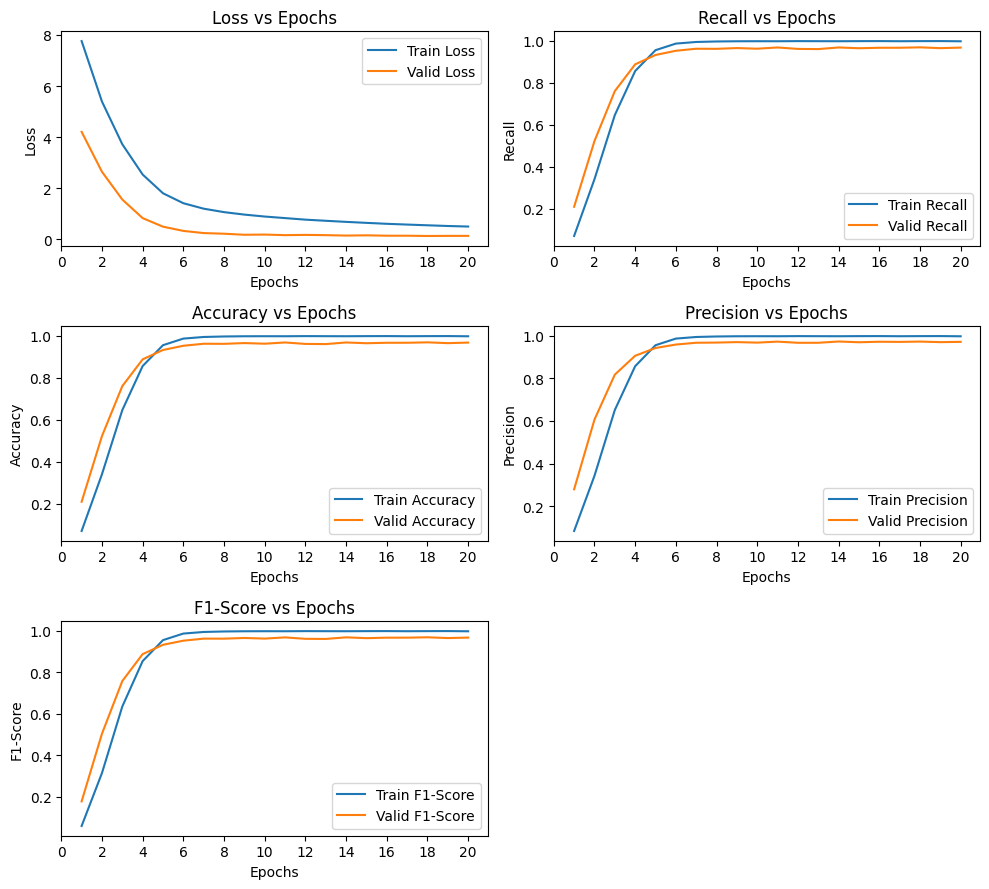

In [ ]:
plot_metrics(metrics_history)

In [ ]:
def test(model, test_loader, test_N):
    total_correct = 0
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            total_correct += (get_batch_predictions(output) == y).sum().item()

            all_preds.extend(get_batch_predictions(output).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    accuracy = total_correct / test_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    print('Test - Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(
         accuracy, precision, recall, f1))

In [ ]:
test(model, test_loader, test_N)

Test - Accuracy: 0.9702 Precision: 0.9750 Recall: 0.9702 F1-Score: 0.9702
